# Import Labreries

In [7]:
!pip install hazm

In [8]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt



from hazm import Normalizer, Stemmer, word_tokenize, Lemmatizer, stopwords_list
from gensim.models import Word2Vec, FastText
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

# Load Data

In [54]:
df= pd.read_csv('/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv',encoding='utf-8', sep='\t+', on_bad_lines='skip')
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [55]:
df.shape

(70000, 3)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   70000 non-null  object
 1   label     70000 non-null  object
 2   label_id  70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [57]:
df.describe()

,label_id
count,70000.000000
mean,0.500000
std,0.500004
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [58]:
df.nunique()

comment     70000
label           2
label_id        2
dtype: int64

# Preprocessing

We ignore unnamed column and then we drop rows which contain nans

In [59]:
df = df[['comment' , 'label' , 'label_id']]
df.dropna(inplace=True)
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


We check if there is a happy label with label_id = 1.0 because thats an exception and the equivalent id for happy is 0.0 and for sad is 1.0

In [60]:
df.query('label == "HAPPY" and label_id == 1.0')

,comment,label,label_id


In [61]:
df.query('label == "SAD" and label_id == 0')

,comment,label,label_id


label_id's type is converted to int

In [62]:
df['label_id'] = df['label_id'].astype(int)
df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


# Visualization

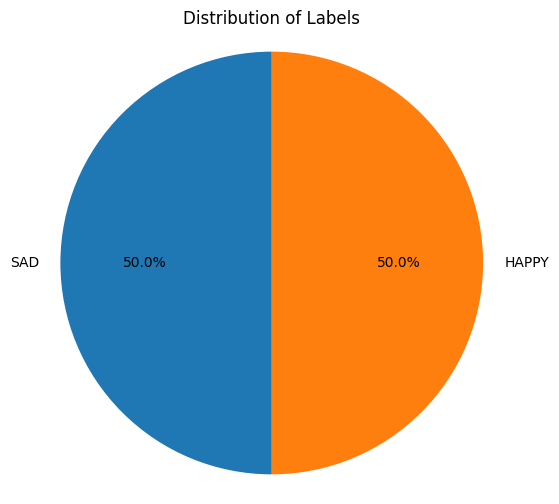

In [63]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Labels')
plt.axis('equal') 
plt.show()


Split data into X and y

In [64]:
X = (df['comment'])
y = (df['label_id'])

X.shape

(70000,)

Remove all punctuation(in both English and Persian), and I also deleted english alphabet in order to have persian text and nothing else.

In [65]:
X = X.apply(lambda x: re.sub(r'[\da-zA-Z\!\(\)\-\[\]\{\}\;\:\'\"\\\,\<\>\.\/\?\@\#\$\%\^\&\*\_\~\؟\،\٪\×\÷\»\«]', '', x))

X.head()

0      واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1    قرار بود  ساعته برسه ولی نیم ساعت زودتر از موق...
2    قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3    عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4                         شیرینی وانیلی فقط یک مدل بود
Name: comment, dtype: object

Split data into train and test

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Use hazm library to make the data more understandable for the model. First we normalize X (both train and test)

In [67]:
normalizer = Normalizer()
X_train = X_train.apply(lambda x: normalizer.normalize(x))
X_test = X_test.apply(lambda x: normalizer.normalize(x))

X_train.head(10)


59891                       فالوده و بستنی عالی بود ممنونم
68020    در بسته اجیل شور فندق مانده وظعم بدی داشت وبقی...
21145    پیک گفت که بیام دم در غذا رو تحویل بگیرم و انت...
44973    سلام زمان ارسال وبرخورد پیک خوب بود ولی واقعا ...
47613    به نسبت بقیه فست فودا قیمتش گرونه کیفیت غذاش خ...
2159     کیفیت غذا خیلی پایین آمده پیتزا سوخته بود و بر...
9279     کبابش عالی بود اما جوجش مونده بود ومزه‌ی خوبی ...
50082           گاتا دو تا سفارش داده بودم اما یکی فرستادن
9155     اصلا فکر نمی‌کردم به این شدت غذا و کیفیتش پایی...
14427           خوشمزه و کم روغ سیب زمینی‌ها هم فوق‌العاده
Name: comment, dtype: object

Use hazm's word tokenizer. As a resualt each word in a sentence was splitted and now in each row we have a list of words

In [68]:
X_train = X_train.apply(lambda x: word_tokenize(x))
X_test = X_test.apply(lambda x: word_tokenize(x))

X_test.head()

37502    [متاسفانه, کلیه, محتویات, شامل, مرغ, سوخاری, و...
46129    [پیتزا, خوب, بود, ولی, سس, نداشت, فکرمیکنم, رس...
58417    [سس, گوجه, ارسالی, به, نسبت, حجم, ساندویچ, خیل...
66017    [کیک, اشکی, شکلاتی, کوچک, کیفیتش, خوب, بود, کی...
37538    [قیمت, تو, فاکتور, اشتباه, بوده, پودر, لباسشوی...
Name: comment, dtype: object

The roots of some word are found by utilizing hazm's lemmatizer

In [69]:
lemmatizer = Lemmatizer()
X_train = X_train.apply(lambda words: [lemmatizer.lemmatize(word) for word in words])
X_test = X_test.apply(lambda words: [lemmatizer.lemmatize(word) for word in words])

X_train.head()

59891             [فالوده, و, بستنی, عالی, بود#است, ممنون]
68020    [در, بسته, اجیل, شور, فندق, مانده, وظعم, بدی, ...
21145    [پیک, گفت#گو, که, بیا, دم, در, غذا, رو, تحویل,...
44973    [سلام, زمان, ارسال, وبرخورد, پیک, خوب, بود#است...
47613    [به, نسبت, بقیه, فس, فودا, قیمت, گرونه, کیفیت,...
Name: comment, dtype: object

At the last step of preprocessing the list of words in each row are now joined to become something like a sentence

In [70]:
X_train = X_train.apply(lambda x: ' '.join(x)).to_list()
X_test = X_test.apply(lambda x: ' '.join(x)).to_list()

# vectorizers

In [71]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(X_train)
x_test = vectorizer.transform(X_test)

# Build & Evaluation Models

In [72]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      6999
           1       0.81      0.90      0.85      7001

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.84     14000
weighted avg       0.85      0.85      0.84     14000



In [73]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      6999
           1       0.81      0.90      0.86      7001

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



In [76]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6999
           1       0.79      0.89      0.84      7001

    accuracy                           0.83     14000
   macro avg       0.84      0.83      0.83     14000
weighted avg       0.84      0.83      0.83     14000



In [77]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      6999
           1       0.83      0.89      0.86      7001

    accuracy                           0.85     14000
   macro avg       0.86      0.85      0.85     14000
weighted avg       0.86      0.85      0.85     14000



# Save the Trained Model

In [78]:
import pickle

with open('xgb.pkl', 'wb') as file:
    pickle.dump(rfc, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)